# Deep learning small homework 3

by Fényes Balázs (NEPTUN: CAU3ZN)

The weather data was downloaded from here: http://idojarasbudapest.hu/archivalt-idojaras

I wrote a small Javascript program to automate the data collection process, which I included: *download_weather.html* (If you want to run it, you will need to download an additional [browser extension](https://addons.mozilla.org/en-US/firefox/addon/cors-everywhere/)), the result is already saved as: *weather.csv*

Because a year can have 366 or 365 days, I decided to store the day of year as a fraction between 0 and 1, instead of an integer.

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import SGD
import numpy as np
from sklearn import preprocessing
from keras import regularizers
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import datetime
%matplotlib inline

import pandas as pd
df = pd.read_csv("weather.csv")
df

/home/osboxes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,DayOfYear,TempC
0,0.7425,18.50
1,0.7452,17.50
2,0.7479,18.00
3,0.7507,18.50
4,0.7534,17.00
5,0.7562,18.50
6,0.7589,18.50
7,0.7616,18.50
8,0.7644,10.50
9,0.7671,9.50


Because the temperature has a yearly periodicity and is continous, when the DayOfYear fraction changes from 1 (=end of the year) to 0 (=beginning of the year), the input to the neural network should also have no sudden change. So I decided to map this fraction to a sine wave:

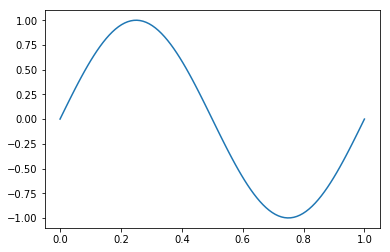

In [2]:
plt.figure()
plt.plot(np.linspace(0,1,100),list(map(lambda f: np.sin(f*2*np.pi), np.linspace(0,1,100))))

Now there are no sudden changes between december and january. But because there is uncertainty about the meaning of for example 0.5, it is necessary to use more sine waves with phase shifts to encode the date of year. Example with 3 sine waves:

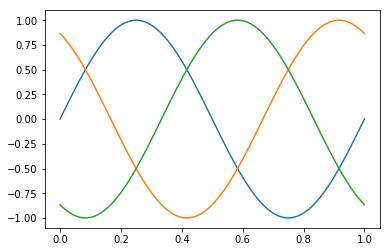

In [3]:
plt.figure()
plt.plot(np.linspace(0,1,100),list(map(lambda f: np.sin(f*2*np.pi), np.linspace(0,1,100))))
plt.plot(np.linspace(0,1,100),list(map(lambda f: np.sin(f*2*np.pi+np.pi/3*2), np.linspace(0,1,100))))
plt.plot(np.linspace(0,1,100),list(map(lambda f: np.sin(f*2*np.pi+np.pi/3*4), np.linspace(0,1,100))))

These values are then used as the input of the neural network. 

Train on 1785 samples, validate on 510 samples
Epoch 1/100
 - 1s - loss: 0.0249 - acc: 0.0011 - val_loss: 0.0084 - val_acc: 0.0059

Epoch 00001: val_loss improved from inf to 0.00836, saving model to weights.hdf5
Epoch 2/100
 - 0s - loss: 0.0185 - acc: 0.0011 - val_loss: 0.0081 - val_acc: 0.0059

Epoch 00002: val_loss improved from 0.00836 to 0.00809, saving model to weights.hdf5
Epoch 3/100
 - 0s - loss: 0.0161 - acc: 0.0011 - val_loss: 0.0080 - val_acc: 0.0059

Epoch 00003: val_loss improved from 0.00809 to 0.00801, saving model to weights.hdf5
Epoch 4/100
 - 0s - loss: 0.0152 - acc: 0.0011 - val_loss: 0.0083 - val_acc: 0.0059

Epoch 00004: val_loss did not improve from 0.00801
Epoch 5/100
 - 0s - loss: 0.0143 - acc: 0.0011 - val_loss: 0.0080 - val_acc: 0.0059

Epoch 00005: val_loss improved from 0.00801 to 0.00799, saving model to weights.hdf5
Epoch 6/100
 - 0s - loss: 0.0142 - acc: 0.0011 - val_loss: 0.0081 - val_acc: 0.0059

Epoch 00006: val_loss did not improve from 0.00799
Epoch

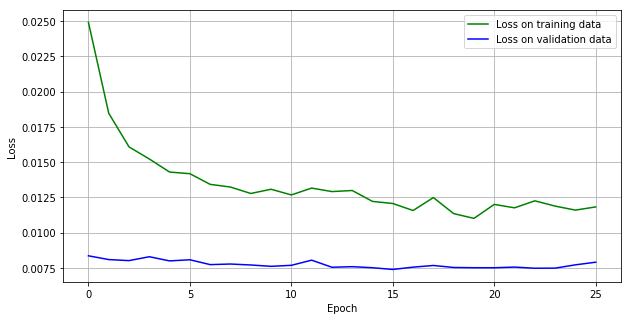

In [4]:
np.random.seed(1)

#save loss for plotting it later
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()
model = Sequential()

# add input layer
model.add(Dense(4, input_shape=(4,)))
model.add(Activation("tanh"))

# add hidden layer
model.add(Dense(4))
model.add(Activation("tanh"))
model.add(Dropout(rate=.25))

# add hidden layer
model.add(Dense(4))
model.add(Activation("tanh"))
model.add(Dropout(rate=.25))

# add hidden layer
model.add(Dense(4))
model.add(Activation("tanh"))
model.add(Dropout(rate=.25))

# add output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

# create inputs to NN
nb_samples=len(df)
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 4), ('output', float, 1)])
for i in range(nb_samples):
    d = df.loc[i]["DayOfYear"] * 2 *np.pi;
    s = 2*np.pi/4;
    samples[i] = (np.sin(d), np.sin(d+s), np.sin(d+2*s), np.sin(d+3*s)), df.loc[i]["TempC"]


# randomize order
np.random.shuffle(samples)
samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]

# standardize inputs
samples_train['input'] = scale(samples_train['input'])
samples_valid['input'] = scale(samples_valid['input'])
samples_test['input'] = scale(samples_test['input'])

# min-max scale outputs
mmscaler = MinMaxScaler()
mmscaler.fit(samples_train["output"].reshape(-1, 1))
samples_train["output"] = mmscaler.transform(samples_train["output"].reshape(-1, 1))[:,0]
mmscaler = MinMaxScaler()
mmscaler.fit(samples_valid["output"].reshape(-1, 1))
samples_valid["output"] = mmscaler.transform(samples_valid["output"].reshape(-1, 1))[:,0]
mmscaler = MinMaxScaler()
mmscaler.fit(samples_test["output"].reshape(-1, 1))
samples_test["output"] = mmscaler.transform(samples_test["output"].reshape(-1, 1))[:,0]

# early stopping, if no improvement
early_stopping=EarlyStopping(patience=10, verbose=1)

# saving best model
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# run training
model.fit(samples_train['input'], samples_train['output'],
          batch_size=16,
          epochs=100,
          verbose=2, 
          validation_data=(samples_valid['input'],samples_valid['output']),
          callbacks=[checkpointer, early_stopping, history], 
          shuffle=True)


# plot loss over time
plt.figure(figsize=(10, 5))
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Loss on training data') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Loss on validation data')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

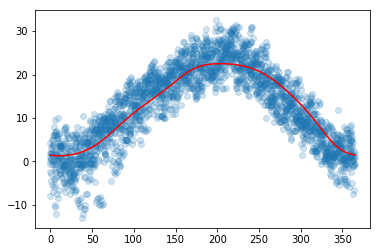

In [5]:
plt.figure()

# draw all data points
plt.scatter(df["DayOfYear"]*365, df["TempC"], alpha=.2)

# create test data
samples = np.zeros(366, dtype = (float, 4))
for i in range(366):
    d = i / 366 * 2 *np.pi
    s = 2*np.pi/4
    samples[i] = np.sin(d), np.sin(d+s), np.sin(d+2*s), np.sin(d+3*s)

# plot prediction over year
y = model.predict(samples)
_min = df["TempC"].min()
_max = df["TempC"].max()
plt.plot(np.linspace(0,365,366),y*(_max-_min)+_min,"r")
#plt.savefig("input_4.png")

The sine wave encoding is working even with 2 sine waves (phase shifted by 90°), but more sine waves improves the accuracy.

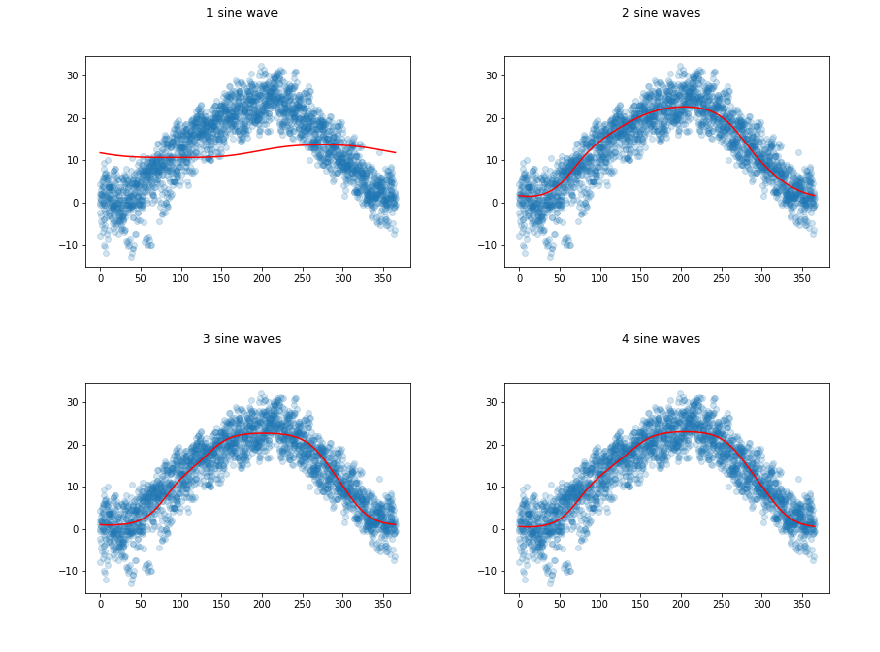

In [6]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.axis("off")
plt.title("1 sine wave")
plt.imshow(plt.imread("input_1.png"))
plt.subplot(222)
plt.axis("off")
plt.title("2 sine waves")
plt.imshow(plt.imread("input_2.png"))
plt.subplot(223)
plt.axis("off")
plt.title("3 sine waves")
plt.imshow(plt.imread("input_3.png"))
plt.subplot(224)
plt.axis("off")
plt.title("4 sine waves")
plt.imshow(plt.imread("input_4.png"))
plt.subplots_adjust(wspace=0, hspace=0)

Use the neural network to predict the daily mean temperature for any day:

In [7]:
def predict_for_day(datestr):
    y, m, d = datestr.split("-")
    date = datetime.date(int(y), int(m), int(d))
    year_begin = datetime.date(int(y), 1, 1)
    days_elapsed = (date - datetime.date(int(y), 1, 1)).days
    days_in_year = (datetime.date(int(y), 12, 31) - datetime.date(int(y), 1, 1)).days+1
    day_of_year_fraction = days_elapsed / days_in_year
    data_points = np.zeros(1, dtype=(float, 4))
    phase_start = day_of_year_fraction * 2 * np.pi
    phase_shift = 2*np.pi/4
    data_points[0] = (np.sin(phase_start), np.sin(phase_start+phase_shift),
                     np.sin(phase_start+2*phase_shift), np.sin(phase_start+3*phase_shift))
    y = model.predict(data_points)[0][0]
    _min = df["TempC"].min()
    _max = df["TempC"].max()
    print("Predicted daily mean temperature for ", datestr, " : ", round(y*(_max-_min)+_min, 1), " °C")

In [8]:
predict_for_day("2018-10-26")
predict_for_day("2018-11-01")
predict_for_day("2018-11-29")

Predicted daily mean temperature for  2018-10-26  :  13.4  °C
Predicted daily mean temperature for  2018-11-01  :  12.2  °C
Predicted daily mean temperature for  2018-11-29  :  5.5  °C


In [9]:
datestr = input("Input date in YYYY-MM-DD format (example: write 2018-12-23 for 2018 december 23rd): ")
predict_for_day(datestr)

Input date in YYYY-MM-DD format (example: write 2018-12-23 for 2018 december 23rd): 2018-12-23
Predicted daily mean temperature for  2018-12-23  :  1.9  °C
